<a href="https://colab.research.google.com/github/Tilakraj-B/cardiac-disease/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import math
from google.colab import drive
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K


In [189]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
dataset_path = "/content/drive/MyDrive/acdc_dataset.zip"  # Update this path
extract_folder = "/content/acdc_data"

In [191]:
# Step 3: Extract the dataset if not already extracted
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [192]:
def extract_cfg_values(file_path):
    config = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):  # Ignore empty lines and comments
                    if ':' in line:
                        key, value = line.split(':', 1)
                        config[key.strip()] = value.strip()
                    elif '=' in line:
                        key, value = line.split('=', 1)
                        config[key.strip()] = value.strip()
        return config
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

In [193]:
def load_nii_file(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    return data


In [194]:
# Step 5: Load and visualize a sample image (Modify the path based on extracted files)
base_dir = os.path.join(extract_folder,"database")
training_folder = os.path.join(extract_folder,"database","training")
testing_folder = os.path.join(extract_folder,"database","testing")
train_patients = [f'patient{i:03d}' for i in range(1, 100)]
test_patients = [f'patient{i:03d}' for i in range(1, 50)]

In [195]:
# Display all the images of a patient

def display_nifti_slices(nifti_path):
    nifti_img = nib.load(nifti_path)  # Load NIfTI file
    image_data = nifti_img.get_fdata()  # Convert to NumPy array

    print(f"\nDisplaying slices for {os.path.basename(nifti_path)}")
    print(f"Image shape: {image_data.shape}")  # Print shape

    dim = image_data.ndim  # Get number of dimensions
    if dim == 2:  # Case: 2D Image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_data, cmap="gray")
        plt.title(f"{os.path.basename(nifti_path)} - 2D Image")
        plt.axis("off")
        plt.show()

    elif dim == 3:  # Case: 3D Image (H, W, D)
        num_slices = image_data.shape[2]
        for i in range(num_slices):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_data[:, :, i], cmap="gray")
            plt.title(f"{os.path.basename(nifti_path)} - Slice {i+1}/{num_slices}")
            plt.axis("off")
            plt.show()

    elif dim == 4:  # Case: 4D Image (H, W, D, T)
        num_slices = image_data.shape[2]
        num_timeframes = image_data.shape[3]
        for t in range(num_timeframes):  # Loop over time
            for i in range(num_slices):  # Loop over depth
                plt.figure(figsize=(6, 6))
                plt.imshow(image_data[:, :, i, t], cmap="gray")
                plt.title(f"{os.path.basename(nifti_path)} - Time {t+1}/{num_timeframes} - Slice {i+1}/{num_slices}")
                plt.axis("off")
                plt.show()

    else:
        print(f"Unsupported image dimension: {dim}")

In [196]:
def extract_roi_adaptive(image, mask, margin_ratio=0.2):
    coords = np.where(mask > 0)
    if not coords[0].any():
        return image, mask

    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])

    # Dynamic margin (e.g., 20% of object height/width)
    h, w = y_max - y_min, x_max - x_min
    margin_y = int(h * margin_ratio)
    margin_x = int(w * margin_ratio)

    y_min = max(y_min - margin_y, 0)
    y_max = min(y_max + margin_y, image.shape[0] - 1)
    x_min = max(x_min - margin_x, 0)
    x_max = min(x_max + margin_x, image.shape[1] - 1)

    return image[y_min:y_max+1, x_min:x_max+1], mask[y_min:y_max+1, x_min:x_max+1]

In [197]:
def resize_with_padding(image, mask, target_size=(80, 80)):
    # Resize image (use linear interpolation)
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)  # Critical for masks

    # Pad to target size
    pad_img = np.zeros((target_size[0], target_size[1]), dtype=image.dtype)
    pad_mask = np.zeros((target_size[0], target_size[1]), dtype=mask.dtype)

    y_offset = (target_size[0] - new_h) // 2
    x_offset = (target_size[1] - new_w) // 2

    pad_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img
    pad_mask[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_mask

    return pad_img, pad_mask

In [198]:
def load_patient_data(patient_folder, es_or_ed):
    # Get all .nii files in the folder
    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES').zfill(2)
    ed = info.get('ED').zfill(2)
    if es_or_ed == 'ES':
      files = [f for f in os.listdir(patient_folder) if f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]
    elif es_or_ed == 'ED':
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii')]
    else :
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii') or f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]

    # Separate image and ground truth files
    image_files = [f for f in files if not f.endswith('_gt.nii')]
    gt_files = [f for f in files if f.endswith('_gt.nii')]
    # print(patient_folder)
    # print(sorted(image_files))
    # print(sorted(gt_files))
    images = []
    masks = []
    roi_images = []
    roi_masks = []
    inh = [0,0,0,0]
    inw = [0,0,0,0]

    for img_file, gt_file in zip(sorted(image_files), sorted(gt_files)):
        img_data = load_nii_file(os.path.join(patient_folder, img_file))
        gt_data = load_nii_file(os.path.join(patient_folder, gt_file))

        #iterating through each slice in the model
        for slice_idx in range(img_data.shape[2]):
            img_slice = img_data[..., slice_idx]
            gt_slice = gt_data[..., slice_idx]

            # Normalize and resize if needed
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())

            # ROI Extraction Step
            img_slice, gt_slice = extract_roi_adaptive(img_slice, gt_slice)
            roi_images.append(img_slice)
            roi_masks.append(gt_slice)

            # Calculate scaling factors
            # roi_height, roi_width = img_slice.shape
            # if(roi_height < 50):
            #   inh[0] += 1
            # elif(roi_height < 100):
            #   inh[1] += 1
            # elif(roi_height < 200):
            #   inh[2]+= 1
            # elif(roi_height < 300):
            #   inh[3] += 1

            # if(roi_width < 50):
            #   inw[0] += 1
            # elif(roi_width < 100):
            #   inw[1] += 1
            # elif(roi_width < 200):
            #   inw[2] += 1
            # elif(roi_width < 300):
            #   inw[3] += 1



            # Resize to make dimensions divisible by 16 for U-Net (optional)
            img_slice, gt_slice = resize_with_padding(img_slice, gt_slice)

            gt_slice_np = gt_slice.astype(np.uint8)   # shape (256,256), values 0/1/2
            unique_labels = np.unique(gt_slice_np)

            gt_slice_cat = tf.keras.utils.to_categorical(gt_slice_np, num_classes=4)  # shape (256,256,4)
            # plt.figure(figsize=(4, 8))
            # plt.subplot(1, 2, 1)
            # plt.imshow(gt_slice_np.squeeze(), cmap='gray')
            # plt.title(f"Ground Slice (Patient {patient_folder})")
            # plt.axis('off')
            # plt.subplot(1, 2, 2)
            # plt.imshow(np.argmax(gt_slice_cat, axis=-1).squeeze(), cmap='viridis') # changed cmap to viridis, gray is not ideal for label maps.
            # plt.title("Ground Truth Image Cat (Labels)")
            # plt.axis('off')
            # plt.tight_layout()
            # plt.show()

            images.append(img_slice)
            masks.append(gt_slice_cat)

    return  np.array(images), np.array(masks), roi_images, roi_masks




In [199]:
def load_dataset(root_folder, patient_range):
    all_images = []
    all_masks = []
    inah = [0,0,0,0]
    inaw = [0,0,0,0]
    for patient_id in patient_range:
        patient_folder = os.path.join(root_folder, f"patient{patient_id:03d}")
        if os.path.exists(patient_folder):
            images, masks, _, _,= load_patient_data(patient_folder , 'EDES')
            all_images.extend(images)
            all_masks.extend(masks)
            # for j in range(0,4):
            #   inah[j] += inh[j]
            #   inaw[j] += inw[j]
        else:
            print(f"Patient folder not found: {patient_folder}")
    # for j in range(0,4):
    #   print("ina",j,inah[j])
    #   print("ina",j,inaw[j])

    return np.array(all_images), np.array(all_masks)


In [ ]:
load_dataset(training_folder, range(1, 101))

In [201]:
def unet(input_size=(80, 80, 1)):
    inputs = Input(input_size)

    # Contracting Path (Encoder) - Reduced depth
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


    # Bottom (reduced filters)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)  # Reduced dropout rate

    # Expansive Path (Decoder) - Symmetric to encoder
    up5 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([conv2, up5], axis=3)
    conv5 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv1, up6], axis=3)
    conv6 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    # Output layer (3 classes with softmax)
    outputs = Conv2D(4, 1, activation='softmax')(conv6)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [202]:
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')  # 💡 make sure both are float32
    y_pred = K.cast(y_pred, 'float32')

    dice = 0
    for c in range(y_true.shape[-1]):
        y_t = y_true[..., c]
        y_p = y_pred[..., c]
        inter = K.sum(y_t * y_p)
        union = K.sum(y_t) + K.sum(y_p)
        dice += (2. * inter + smooth) / (union + smooth)

    return dice / y_true.shape[-1]  # mean over all classes

tf.keras.utils.get_custom_objects().update({'dice_coef_multiclass': dice_coef_multiclass})


In [203]:
def cosine_annealing(epoch, lr):
    """
    Cosine annealing from max_lr down to min_lr over total_epochs.
    """
    max_lr = 1e-3
    min_lr = 1e-4
    total_epochs = 100  # match your training epochs

    # compute new learning rate
    cos_inner = (math.pi * (epoch % total_epochs)) / total_epochs
    new_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(cos_inner))
    return new_lr


In [204]:
def train_model():
    # Load training data
    train_images, train_masks = load_dataset(training_folder, range(1, 101))

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )

        # Data augmentation
    # datagen = ImageDataGenerator(
    # rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    # zoom_range=0.1, horizontal_flip=True, brightness_range=(0.8,1.2),
    # fill_mode='nearest'
    # )
    # train_generator = datagen.flow(X_train, y_train, batch_size=8)  #

    # Create model
    model = unet()
    model.compile(
    optimizer=tf.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', dice_coef_multiclass]
)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_loss',restore_best_weights=True),
        LearningRateScheduler(cosine_annealing, verbose=1)
    ]

    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=100,
        callbacks=callbacks
    )

    return model, history

In [205]:
def apply_kmeans_with_filters(segmented_image, k=3):

    # Apply Gaussian smoothing filter
    smoothed_image = cv2.GaussianBlur(segmented_image, (5, 5), 0)

    # Define a sharpening kernel and apply it
    kernel_sharpening = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(smoothed_image, -1, kernel_sharpening)

    # Flatten the sharpened image for clustering
    flat_image = sharpened_image.reshape(-1, 1)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(flat_image)

    # Reshape the cluster labels back to the original image shape
    clustered = kmeans.labels_.reshape(segmented_image.shape)
    return clustered, smoothed_image, sharpened_image


In [206]:
def evaluate_model(model): # added testing_folder as an argument.
    # Load test data
    test_images, test_masks = load_dataset(testing_folder, range(101, 151))  # Assuming test data range is 101-150

    # Evaluate
    results = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

    # Predict
    predicted_probs = model.predict(test_images[:10]) # Get the probabilities.
    predicted_masks = np.argmax(predicted_probs, axis=-1) # Get the class label.

    plt.figure(figsize=(20, 10))
    for i in range(10):
        original_image = test_images[i].squeeze()
        true_mask = test_masks[i].squeeze()
        pred_mask = predicted_masks[i].squeeze() # No need to squeeze for binary masks.

        # Extract predicted region
        # segmented_image = original_image * pred_mask  # Element-wise multiplication


        plt.subplot(3, 10, i + 1) # reduced to 3 rows.
        plt.imshow(original_image, cmap='jet')
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, 10, i + 11)
        plt.imshow(np.argmax(true_mask, axis=-1).squeeze(), cmap='jet') # changed the true mask to argmax.
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(3, 10, i + 21)
        plt.imshow(pred_mask, cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



In [207]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


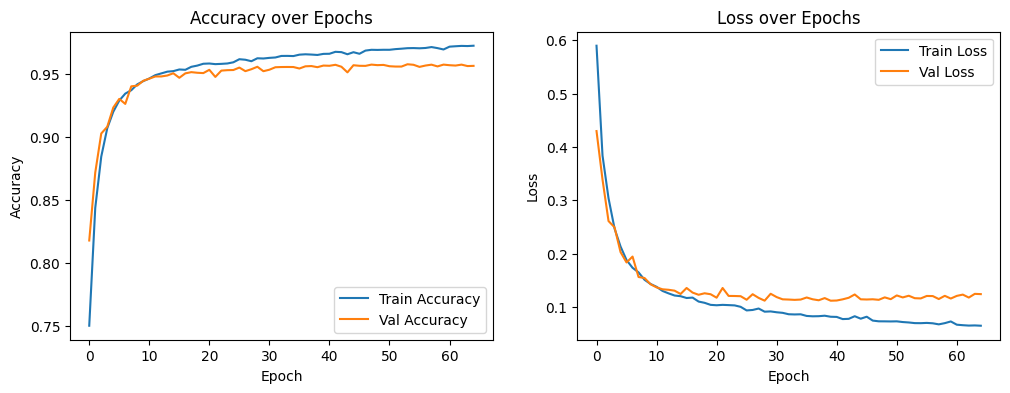

In [208]:
import json

if not os.path.exists('unet_mri_segmentation.keras'):
    model, history = train_model()

    # Save model
    model.save('unet_mri_segmentation.keras')

    # Save training history
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    plot_training_history(history)
else:
    model = tf.keras.models.load_model('unet_mri_segmentation.keras')

    # Load training history if needed
    if os.path.exists('training_history.json'):
        with open('training_history.json', 'r') as f:
            history_data = json.load(f)

        # Create a dummy History object if needed
        class DummyHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        history = DummyHistory(history_data)
        plot_training_history(history)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9576 - dice_coef_multiclass: 0.8978 - loss: 0.1163
Test Loss: 0.12506531178951263, Test Accuracy: 0.9563062191009521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


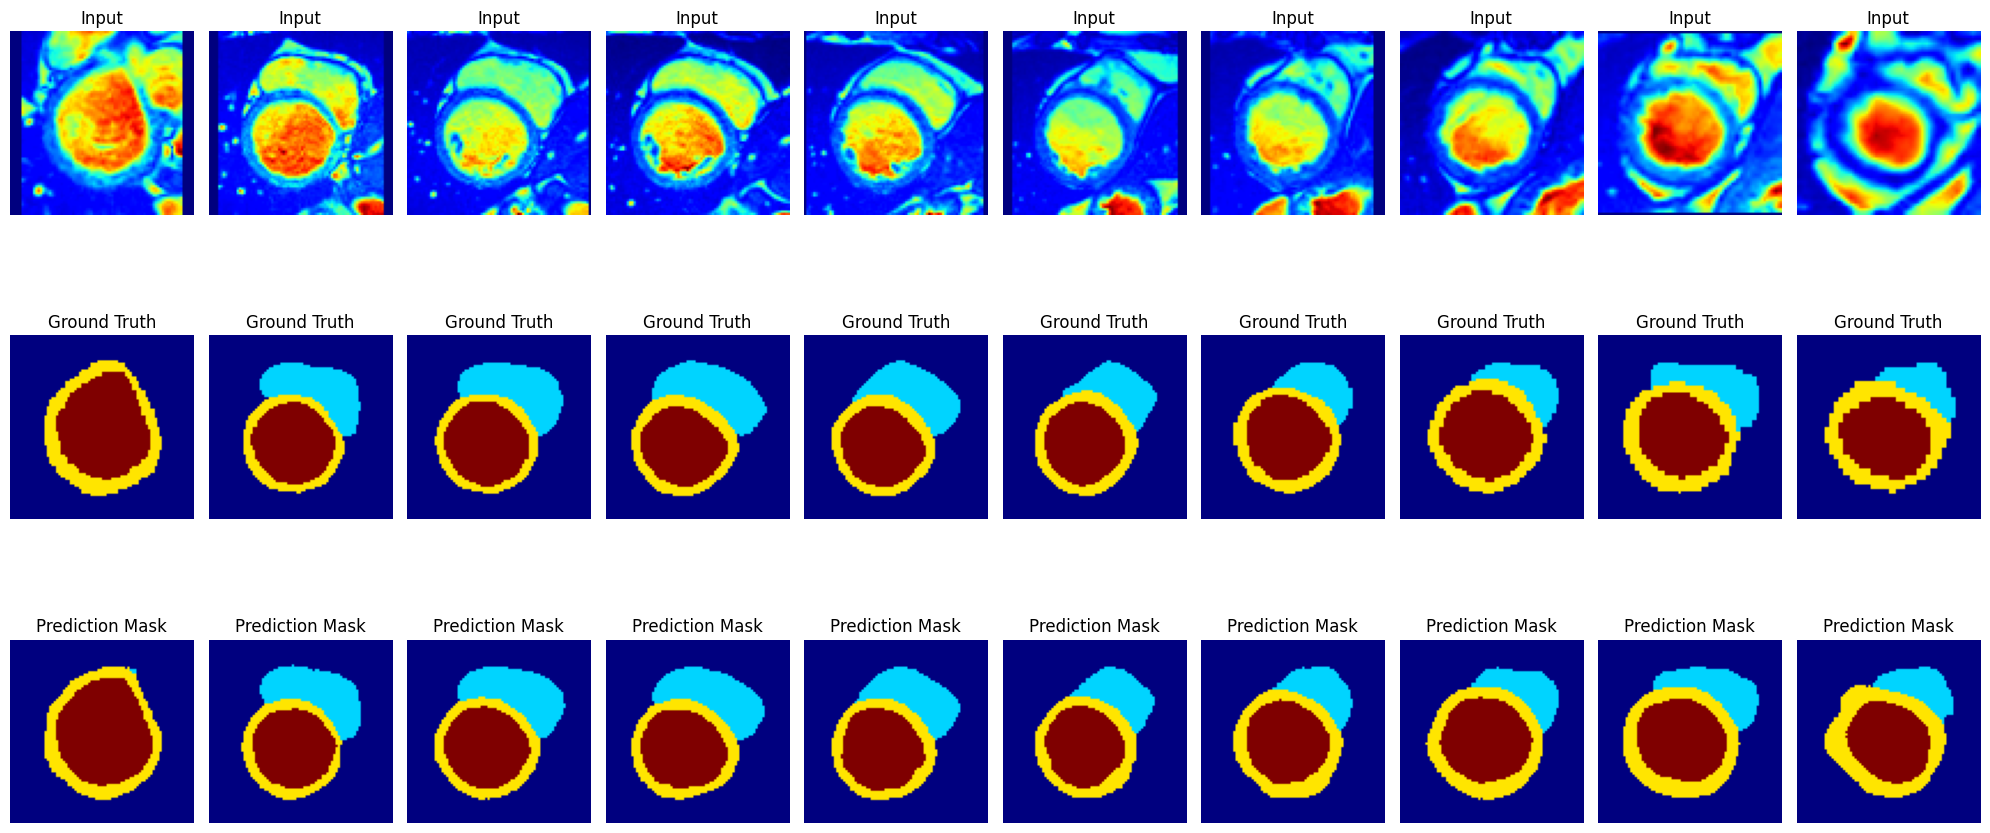

In [209]:
    # Evaluate on test set
    evaluate_model(model)

In [210]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice coefficient."""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


In [221]:
def resize_predicted_masks(predicted_masks, original_roi):
    original_masks_resized = []

    for j in range(len(predicted_masks)):
        original_height, original_width = original_roi[j].shape

        # Resize the mask
        rescaled_mask = tf.image.resize(predicted_masks[j], [original_height, original_width], method='nearest')
        original_masks_resized.append(rescaled_mask)
    return original_masks_resized

In [238]:
def calculate_class_volumes(pred_mask_resized, nii_file_path, threshold=0.5):
    """
    Calculate volume (in mL) for a specific class from predicted masks
    using voxel dimensions from the original NIfTI file

    Args:
        pred_mask_resized: Resized prediction mask [slices, height, width, channels]
        nii_file_path: Path to original NIfTI file for spacing information
        class_channel: Channel index containing the target class (default: 3 for 4th class)
        threshold: Probability threshold for binarization (default: 0.5)

    Returns:
        Volume in milliliters (mL)
    """
    # Load NIfTI header for voxel dimensions
    img = nib.load(nii_file_path)
    # spacing = img.header.get_zooms()[:3]  # Get (dx, dy, dz)
    header = img.header
    pixdims = header['pixdim']
    pixel_spacing_x = pixdims[1]
    pixel_spacing_y = pixdims[2]
    slice_thickness = pixdims[3]
    # print("pixel_spacing_x",pixel_spacing_x)
    # print("pixel_spacing_y",pixel_spacing_y)
    # print("slice_thickness",slice_thickness)

    #         # Calculate the number of voxels (pixels) that are part of the segmented structure
    # print(pred_mask_resized[:,:,3].shape)
    # plt.figure(figsize=(4,4))
    # plt.subplot(1,1,1)
    # plt.imshow(pred_mask_resized[:,:,3])
    # plt.show()
    num_voxels = np.sum(pred_mask_resized[:,:,3] > 0.5).astype(np.uint8)
        # Calculate the volume
    volume = num_voxels * pixel_spacing_x * pixel_spacing_y * slice_thickness #mm3

    return volume/1000 #mL



In [236]:
def eval():

  for i in range(101, 151):
    patient_folder = os.path.join(testing_folder, f"patient{i:03d}")

    ED_test_images, ED_test_masks, ED_roi_images, ED_roi_masks = load_patient_data(patient_folder , 'ED')
    ES_test_images, ES_test_masks, ES_roi_images, ES_roi_masks = load_patient_data(patient_folder , 'ES')

    ED_predicted_mask = model.predict(ED_test_images)
    ES_predicted_mask = model.predict(ES_test_images)

    ED_predicted_mask_resized = resize_predicted_masks(ED_predicted_mask, ED_roi_masks)
    ES_predicted_mask_resized = resize_predicted_masks(ES_predicted_mask, ES_roi_masks)

    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES').zfill(2)
    ed = info.get('ED').zfill(2)

    ED_file = os.path.join(patient_folder,f"patient{i:03d}_frame{ed}.nii")
    ES_file = os.path.join(patient_folder,f"patient{i:03d}_frame{es}.nii")
    ED_volume = 0
    ES_volume = 0
    ED_volume_gt = 0
    ES_volume_gt = 0


    for j in range(len(ED_predicted_mask_resized)):

      ED_volume += calculate_class_volumes(ED_predicted_mask_resized[j], ED_file)
      ES_volume += calculate_class_volumes(ES_predicted_mask_resized[j], ES_file)
      ED_volume_gt += calculate_class_volumes(ED_test_masks[j], ED_file)
      ES_volume_gt += calculate_class_volumes(ED_test_masks[j], ES_file)

    stroke_volume = ED_volume - ES_volume
    ejection_fraction = (stroke_volume / ED_volume) * 100
    print(f"Patient {i:03d}: ED Volume = {ED_volume:.2f} mL, ES Volume = {ES_volume:.2f} mL")
    print(f"Patient {i:03d}: Stroke Volume = {stroke_volume:.2f} mL, Ejection Fraction = {ejection_fraction:.2f}%")
    print(f"Patient {i:03d}: ED Volume GT = {ED_volume_gt:.2f} mL, ES Volume GT = {ES_volume_gt:.2f} mL")





In [239]:
eval()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Patient 101: ED Volume = 32.06 mL, ES Volume = 22.69 mL
Patient 101: Stroke Volume = 9.37 mL, Ejection Fraction = 29.22%
Patient 101: ED Volume GT = 35.34 mL, ES Volume GT = 35.34 mL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Patient 102: ED Volume = 24.73 mL, ES Volume = 14.33 mL
Patient 102: Stroke Volume = 10.40 mL, Ejection Fraction = 42.05%
Patient 102: ED Volume GT = 18.33 mL, ES Volume GT = 18.33 mL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Patient 103: ED Volume = 21.24 mL, ES Volume = 18.75 mL
Patient 103: Stroke Volume = 2.49 mL, Ejection Fraction = 11.72%
Patient 103: ED Volume GT = 32.54 mL, ES Volume GT = 32.54 mL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Patient 104: ED Volume = 22.58 mL, ES Volume = 12.73 mL
Patient 104: Stroke Volume = 9.85 mL, Ejection Fraction = 43.63%
Patient 104: ED Volume GT

KeyboardInterrupt: 